In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Load Data & EDA

In [9]:
# Load the data
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# # load images from images folder for each ID
# train_images = []
# for i in train['Id'].astype(str):
#     if len(i) < 4:
#         i = '0'*(4-len(i)) + i
#     img = keras.preprocessing.image.load_img('images/'+str(i)+'.jpg', target_size=(224, 224))
#     img_array = keras.preprocessing.image.img_to_array(img)
#     train_images.append(img_array)
#     if len(train_images) % 500 == 0:
#         print(len(train_images))

# # convert to numpy array
# train_images = np.array(train_images)

train.Id = train.Id.astype(str)
test.Id = test.Id.astype(str)

for i in train.Id:
    if len(str(i)) < 4:
        train.Id = train.Id.replace(i, '0'*(4-len(str(i))) + str(i)).astype(str)

for i in test.Id:
    if len(str(i)) < 4:
        test.Id = test.Id.replace(i, '0'*(4-len(str(i))) + str(i)).astype(str)

def append_ext(fn):
    return fn+".jpg"

train["Id"]=train["Id"].apply(append_ext)
test["Id"]=test["Id"].apply(append_ext)

classes = train['label'].unique().tolist()



In [10]:
train.head()

,Id,label
0,2441.jpg,glass
1,0000.jpg,cup
2,2442.jpg,glass
3,6535.jpg,spoon
4,4814.jpg,plate


In [11]:
print(f'Total number of classes: {train["label"].nunique()}')
print(f'Total number of images for training: {train.shape[0]}')
print(f'Total number of images for testing: {test.shape[0]}')
print(f'Total train + test images: {train.shape[0] + test.shape[0]}')

import os
print(f'Total number of images in the images folder: {len(os.listdir("images"))}')

Total number of classes: 6
Total number of images for training: 5559
Total number of images for testing: 3808
Total train + test images: 9367
Total number of images in the images folder: 9367


Number of images per class:


<AxesSubplot: >

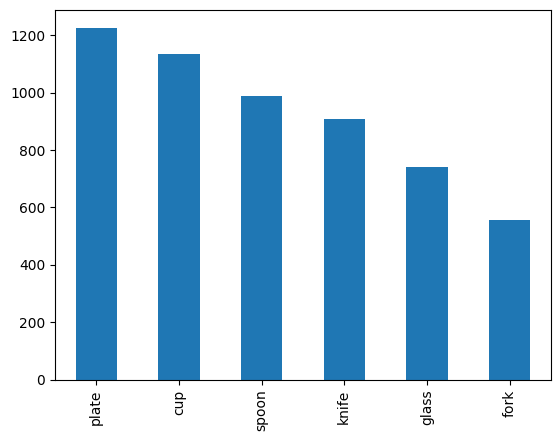

In [12]:
print('Number of images per class:')
train['label'].value_counts().plot(kind='bar')

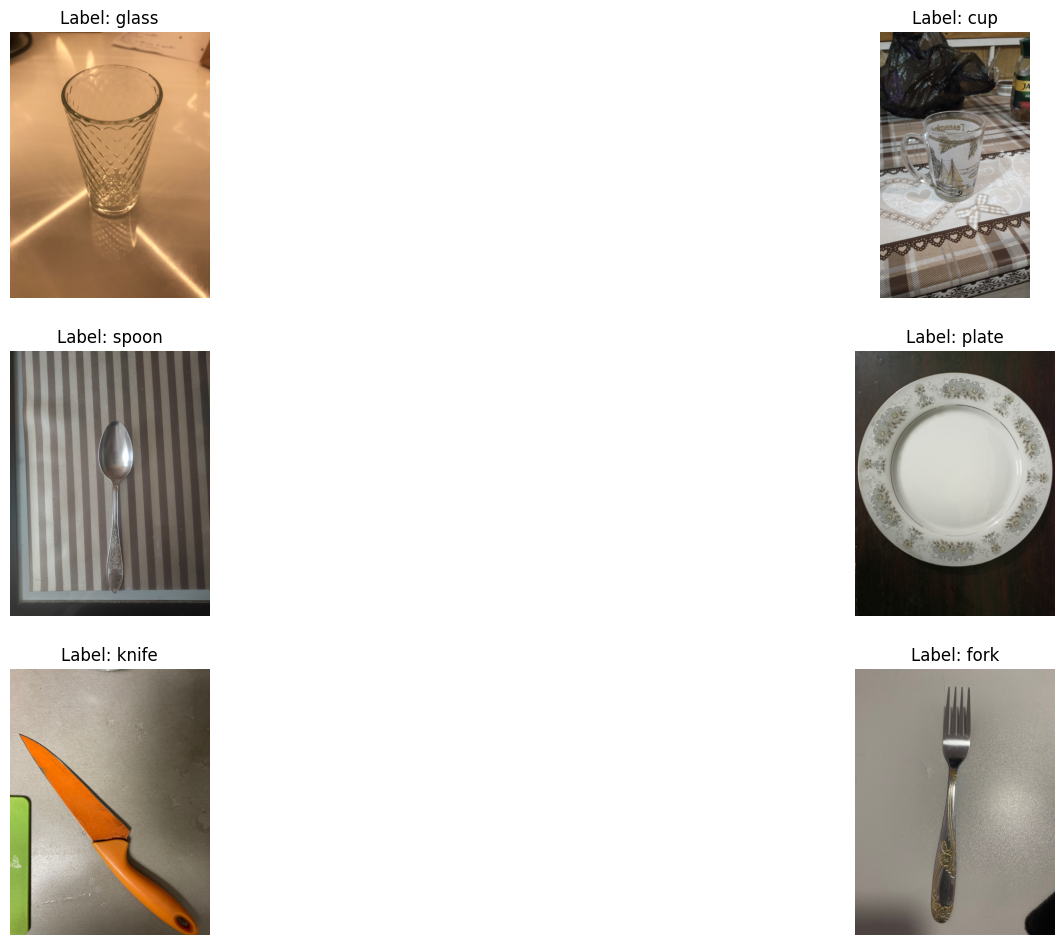

In [13]:
# Display single image for each class
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns
%matplotlib inline

plt.figure(figsize=(20, 20))

for i, c in enumerate(classes):
    plt.subplot(5, 2, i+1)
    img = mpimg.imread('images/' + train[train['label'] == c]['Id'].values[0])
    plt.imshow(img)
    plt.title(f'Label: {c}')
    plt.axis('off')
    i += 1
plt.show()

# Predict Pretrained Model

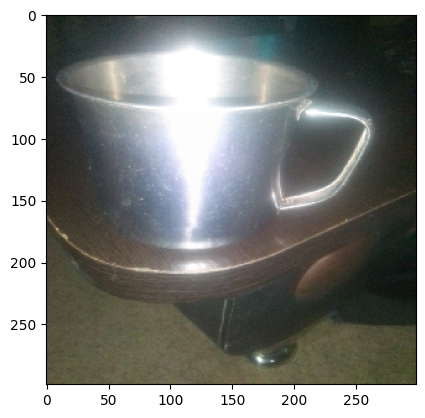

1/1 [==============================] - 1s 1s/step


[('n07930864', 'cup', 0.31210485),
 ('n03063599', 'coffee_mug', 0.06496241),
 ('n07920052', 'espresso', 0.04197007)]

In [14]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import load_img
import numpy as np

model = Xception(weights='imagenet', input_shape=(299, 299, 3))

x = load_img('images/0001.jpg', target_size=(299, 299))
x = np.array(x)
X = np.expand_dims(x, axis=0)
X = preprocess_input(X)

# display the image
plt.imshow(x/255.)
plt.show()

pred = model.predict(X)
decode_predictions(pred, top=3)[0]

# Training a model to classify kitchenware

In [18]:
# Training baseline model with Xception
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_gen.flow_from_dataframe(
    dataframe=train,
    directory='images/',
    x_col='Id',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_gen.flow_from_dataframe(
    dataframe=train,
    directory='images/',
    x_col='Id',
    y_col='label',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# save train_generator.class_indices to a file
import json
with open('./models/class_indices.json', 'w') as f:
    json.dump(train_generator.class_indices, f)


Found 4448 validated image filenames belonging to 6 classes.
Found 1111 validated image filenames belonging to 6 classes.


In [16]:
base_model = Xception(weights='imagenet', include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(299, 299, 3))

base = base_model(inputs, training=False)

vectors = GlobalAveragePooling2D()(base)

outputs = Dense(6, activation='softmax')(vectors)

model = Model(inputs, outputs)


In [12]:
learning_rate = 0.0001
epochs = 10
batch_size = 32
optimizer = Adam(lr=learning_rate)
loss = keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


/Users/mahesh.sinha/opt/anaconda3/envs/ml-zoomcamp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[
        ModelCheckpoint('./models/model.h5', save_best_only=True),
        EarlyStopping(patience=3)
    ]
)



Epoch 1/10
139/139 [==============================] - 443s 3s/step - loss: 1.2520 - accuracy: 0.7055 - val_loss: 0.9004 - val_accuracy: 0.8794
Epoch 2/10
139/139 [==============================] - 485s 3s/step - loss: 0.7077 - accuracy: 0.9038 - val_loss: 0.5667 - val_accuracy: 0.9244
Epoch 3/10
139/139 [==============================] - 487s 4s/step - loss: 0.4821 - accuracy: 0.9323 - val_loss: 0.4183 - val_accuracy: 0.9343
Epoch 4/10
139/139 [==============================] - 496s 4s/step - loss: 0.3738 - accuracy: 0.9395 - val_loss: 0.3371 - val_accuracy: 0.9424
Epoch 5/10
139/139 [==============================] - 478s 3s/step - loss: 0.3119 - accuracy: 0.9433 - val_loss: 0.2894 - val_accuracy: 0.9460
Epoch 6/10
139/139 [==============================] - 477s 3s/step - loss: 0.2721 - accuracy: 0.9445 - val_loss: 0.2566 - val_accuracy: 0.9451
Epoch 7/10
139/139 [==============================] - 480s 3s/step - loss: 0.2445 - accuracy: 0.9472 - val_loss: 0.2322 - val_accuracy: 0.9478

In [14]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

{}

In [11]:
# predict on test set
test_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_gen.flow_from_dataframe(
    dataframe=test,
    directory='images/',
    x_col='Id',
    y_col=None,
    target_size=(299, 299),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

model = keras.models.load_model('model.h5')

pred = model.predict(test_generator)

# decode predictions
pred = np.argmax(pred, axis=1)

# class labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in pred]

# create submission file
sub = pd.DataFrame({'Id': test.Id, 'label': predictions})
sub.to_csv('submission.csv', index=False)


import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
# Load the data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# # load images from images folder for each ID
# train_images = []
# for i in train['Id'].astype(str):
#     if len(i) < 4:
#         i = '0'*(4-len(i)) + i
#     img = keras.preprocessing.image.load_img('images/'+str(i)+'.jpg', target_size=(224, 224))
#     img_array = keras.preprocessing.image.img_to_array(img)
#     train_images.append(img_array)
#     if len(train_images) % 500 == 0:
#         print(len(train_images))

# # convert to numpy array
# train_images = np.array(train_images)

for i in train.Id:
    if len(str(i)) < 4:
        train.Id = train.Id.replace(i, '0'*(4-len(str(i))) + str(i)).astype(str)+'.jpg'

for i in test.Id:
    if len(str(i)) < 4:
        test.Id = test.Id.replace(i, '0'*(4-len(str(i))) + str(i)).astype(str)+'.jpg'
train.head()
# Load the data
train = pd.read_csv('train.csv')
test = pd.

In [16]:
# check for all test images in images folder
test = pd.read_csv('./data/test.csv')

test.Id = test.Id.astype(str)

for i in test.Id:
    if len(str(i)) < 4:
        test.Id = test.Id.replace(i, '0'*(4-len(str(i))) + str(i)).astype(str)

def append_ext(fn):
    return fn+".jpg"

test["Id"]=test["Id"].apply(append_ext)


import os
count = 0
for i in test.Id:
    if i not in os.listdir('images/'):
        count += 1
        print(i)

# Predict single image

In [40]:
def predict_single(image_url, web=True):
    from tensorflow import keras
    import numpy as np
    import json

    # predict from image url from the web
    import requests
    from PIL import Image
    from io import BytesIO

    if web:
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))
    else:
        img = Image.open(image_url)

    # preprocess image
    from tensorflow.keras.applications.xception import preprocess_input
    img = img.resize((299, 299))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # load model
    model = keras.models.load_model('./models/model_kaggle.h5')

    # load class indices
    with open('./models/class_indices.json', 'r') as f:
        class_indices = json.load(f)

    # predict and decode along with probabilities
    preds = model.predict(img)
    pred = np.argmax(preds, axis=1)
    labels = dict((v,k) for k,v in class_indices.items())
    predictions = [labels[k] for k in pred][0]
    prob = np.max(preds, axis=1)[0]
    return {'Label': predictions, 'Probability': prob}


predict_single('https://www.baladeo.com/medias/produits/1630258919/1710_1280-security-kinfe-emergency-yellow.jpg')

1/1 [==============================] - 1s 712ms/step


{'Label': 'knife', 'Probability': 0.8949804}

In [27]:
json.load(open('./models/class_indices.json'))

{'cup': 0, 'fork': 1, 'glass': 2, 'knife': 3, 'plate': 4, 'spoon': 5}